In [105]:
## Step 1 - Import the Libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

## Step 2 – Reading our training data and getting our training data in shape
def load_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data.reset_index(inplace=True)
    data.drop(['Adj Close'], axis=1, inplace=True)
    return data

def feature_engineering(data):
    data['SMA_10'] = data['Close'].rolling(window=10).mean()
    data['SMA_50'] = data['Close'].rolling(window=50).mean() 
    data.dropna(inplace=True)
    return data

# Define the stock ticker and the training time frame
stock_ticker = "TSLA"
start_date = "2015-01-01"  # Start with a long enough historical period
end_date = "2024-01-01"

In [106]:
training_features = dataset_train[['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'SMA_50']].values
scaler = MinMaxScaler(feature_range=(0, 1))
training_features_scaled = scaler.fit_transform(training_features)

def create_training_data(data, time_step):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i])
        y.append(data[i, 3])  # Predicting 'Close' price
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_training_data(training_features_scaled, time_step)

In [107]:
## Step 3 – Creating the Stock Price Prediction model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = build_lstm_model((X_train.shape[1], X_train.shape[2]))

model.fit(X_train, y_train, epochs=60, batch_size=32)

Epoch 1/60


C:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 0.0234
Epoch 2/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0042
Epoch 3/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0043
Epoch 4/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0043
Epoch 5/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0032
Epoch 6/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0029
Epoch 7/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0024
Epoch 8/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0029
Epoch 9/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0021
Epoch 10/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0022
Epoch 11/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0023
Epoch 12/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0021
Epoch 13/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0019
Epoch 14/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0017
Epoch 15/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0016
Epoch 16/60
68/

In [108]:
## Step 5 – Predicting the Next 30 Days
# Load the most recent data for prediction, including some overlap with training data
prediction_start_date = "2023-12-01"
prediction_end_date = "2024-03-01"
dataset_recent = load_stock_data(stock_ticker, prediction_start_date, prediction_end_date)
dataset_recent = feature_engineering(dataset_recent)

recent_features = dataset_recent[['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'SMA_50']].values
combined_data = np.concatenate((training_features[-time_step:], recent_features), axis=0)
inputs = scaler.transform(combined_data)

X_test = []
for i in range(time_step, len(inputs)):
    X_test.append(inputs[i-time_step:i])
X_test = np.array(X_test)

predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(np.concatenate((np.zeros((predicted_stock_price.shape[0], inputs.shape[1] - 1)), predicted_stock_price), axis=1))[:, 3]
predicted_stock_price

[*********************100%%**********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


array([9.57800007, 9.57800007, 9.57800007, 9.57800007, 9.57800007,
       9.57800007, 9.57800007, 9.57800007, 9.57800007, 9.57800007,
       9.57800007, 9.57800007])

ValueError: x and y must have same first dimension, but have shapes (0,) and (12,)

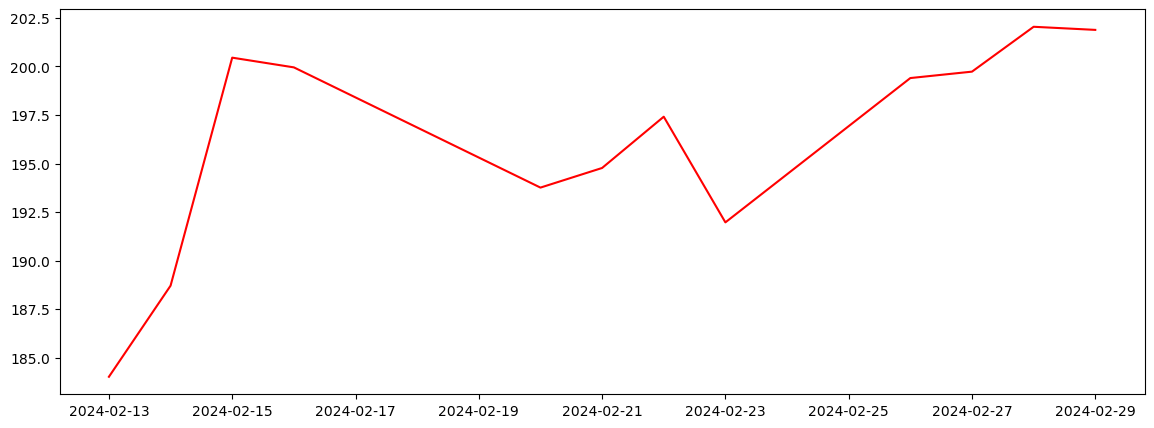

In [109]:
plt.figure(figsize=(14, 5))
plt.plot(dataset_recent['Date'], dataset_recent['Close'].values, color='red', label='Real TSLA Stock Price')
plt.plot(dataset_recent['Date'][time_step:], predicted_stock_price, color='blue', label='Predicted TSLA Stock Price')
plt.title('TSLA Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('TSLA Stock Price')
plt.legend()
plt.show()